Grad-CAM for CNN visualization (updated according to https://keras.io/examples/vision/grad_cam/)

# 1. Prepare the environment

In [1]:
import sys
print( f"Python {sys.version}\n" )

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )

# For image resizing
import cv2 as cv
print( f"OpenCV {cv.__version__}\n" )

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.10.14 (main, May  6 2024, 14:42:37) [Clang 14.0.6 ]

NumPy 1.26.4

Matplotlib 3.9.0

OpenCV 4.10.0

TensorFlow 2.16.1
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


# 2. Load the model to inspect

Be careful, when the last layer of the model includes any activation function (e.g., Softmax) and doesn't output raw prediction scores (=logits).
- Previously, we had to manually separate the softmax function from the last layer by creating a new output layer (without an activation function) and copying weights from the old one.
- Now, when loading a model, there is an option that allows us to include or exclude the activation function of the output layer.
> https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16 `classifier_activation` (default = 'softmax'):	A str or callable. The activation function to use on the "top" layer. Ignored unless include_top=True. Set classifier_activation=None to return the logits of the "top" layer. When loading pretrained weights, classifier_activation can only be None or "softmax".

In [2]:
# Load the pre-trained VGG16 model *without* the softmax activation in the output layer
base_model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=True, classifier_activation=None) 

base_model.summary()

2024-06-30 23:20:02.706576: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-06-30 23:20:02.706606: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-06-30 23:20:02.706612: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-06-30 23:20:02.706638: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-30 23:20:02.706654: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Check the activation function of the output layer (=the last layer):

In [3]:
print( base_model.layers[-1].activation )

<function linear at 0x3031e44c0>


# 3. Adapt the base model

In [4]:
def alter_model_for_GradCAM( model, last_conv_layer_name ):
    # 1. Get the output from the last convolutional layer
    last_conv_output = model.get_layer( last_conv_layer_name ).output

    # 2. Create the new model with one additional output
    new_model = tf.keras.Model( inputs=model.inputs, outputs=[model.output, last_conv_output] )

    return new_model

new_model = alter_model_for_GradCAM( base_model, 'block5_pool' )
new_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
new_model.inputs

AttributeError: 'Functional' object has no attribute 'input_names'

In [55]:
new_model.output_names

ListWrapper(['predictions', 'block5_pool'])

# 4. Custom ImageNet's decode_predictions

In [56]:
def my_imagenet_decode_predictions( preds, top=5 ):
    """
    This function is adapted from https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
    The adaptation is done so that ImageNet's class indices (0-999) are included in the function's outputs.

    Arguments:
        preds (numpy array): a batch of ImageNet's prediction outputs
        top (int): only decode 'top' classes with maximum scores

    Return a tuple of:
        Output[0]: a dict of { class_index:class_name } regarding the whole ImageNet dataset
        Output[1]: a 4D tuple of (class_index, class_name, class_description, score)
            Note that 'score' can be prediction values with or without the softmax activation, depending on the input 'preds'
    """
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                                 'a batch of predictions '
                                 '(i.e. a 2D array of shape (samples, 1000)). '
                                 'Found array with shape: ' + str(preds.shape))

    import json

    CLASS_INDEX_PATH = ('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
    fpath = tf.keras.utils.get_file( 'imagenet_class_index.json',
                                                CLASS_INDEX_PATH,
                                                cache_subdir='models',
                                                file_hash='c2c37ea517e94d9795004a39431a14cb' )
    with open(fpath) as f:
        CLASS_INDEX = json.load(f)
        CLASS_INDEX = dict( zip( [ int(i) for i in CLASS_INDEX.keys() ], CLASS_INDEX.values() ) )

    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [ (i,) + tuple(CLASS_INDEX[i]) + (pred[i],) for i in top_indices ]
        result.sort(key=lambda x: x[-1], reverse=True)
        results.append(result)

    return CLASS_INDEX, results

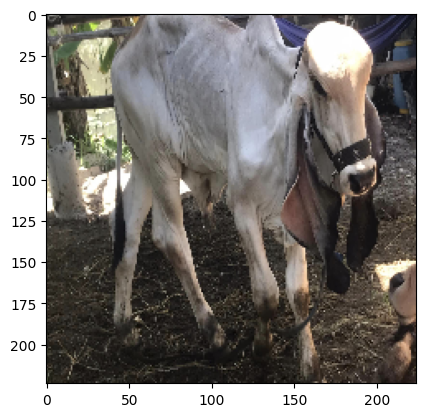

In [101]:
# Load images (from disk) as PIL.Image.Image
img_path1 = '/Users/Lemon/workspace/Projects/HW/OG/I_106.jpeg'
#img_path2 = 'grad_cam_12_0.jpg'
img1 =  tf.keras.preprocessing.image.load_img(img_path1, target_size=(224, 224))
#img2 =  tf.keras.preprocessing.image.load_img(img_path2, target_size=(224, 224))

# Convert PIL Images to NumPy ndarrays
img1 = tf.keras.preprocessing.image.img_to_array(img1).astype(np.uint8)
#img2 = tf.keras.preprocessing.image.img_to_array(img2).astype(np.uint8)

# Display the NumPy images
plt.imshow(img1); plt.show()
#plt.imshow(img2); plt.show()

In [102]:
# Preprocess the input images according to VGG16's requirements
img_preprocess1 = tf.keras.applications.vgg16.preprocess_input( np.expand_dims(img1, axis=0) )
#img_preprocess2 = tf.keras.applications.vgg16.preprocess_input( np.expand_dims(img2, axis=0) )

Compare the original model and our new model to make sure that they produce identical results

In [103]:
# Original model
out_linear1 = base_model.predict( img_preprocess1 )
#out_linear2 = base_model.predict( img_preprocess2 )

imagenet_dict, result1 = my_imagenet_decode_predictions( out_linear1, top=10 )
#imagenet_dict, result2 = my_imagenet_decode_predictions( out_linear2, top=10 )
print( result1 )
#print( result2 )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[[(690, 'n03868242', 'oxcart', 16.548775), (345, 'n02403003', 'ox', 15.43456), (730, 'n03967562', 'plow', 11.73559), (912, 'n04604644', 'worm_fence', 9.945098), (346, 'n02408429', 'water_buffalo', 9.823413), (353, 'n02423022', 'gazelle', 8.617271), (348, 'n02412080', 'ram', 8.587846), (167, 'n02089973', 'English_foxhound', 8.302014), (603, 'n03538406', 'horse_cart', 8.290426), (354, 'n02437312', 'Arabian_camel', 7.9774756)]]


In [104]:
# Our modified model
out_linear1, _ = new_model.predict( img_preprocess1 )
#out_linear2, _ = new_model.predict( img_preprocess2 )

imagenet_dict, result1 = my_imagenet_decode_predictions( out_linear1, top=10 )
#imagenet_dict, result2 = my_imagenet_decode_predictions( out_linear2, top=10 )
print( result1 )
#print( result2 )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
[[(690, 'n03868242', 'oxcart', 16.548775), (345, 'n02403003', 'ox', 15.43456), (730, 'n03967562', 'plow', 11.73559), (912, 'n04604644', 'worm_fence', 9.945098), (346, 'n02408429', 'water_buffalo', 9.823413), (353, 'n02423022', 'gazelle', 8.617271), (348, 'n02412080', 'ram', 8.587846), (167, 'n02089973', 'English_foxhound', 8.302014), (603, 'n03538406', 'horse_cart', 8.290426), (354, 'n02437312', 'Arabian_camel', 7.9774756)]]


# 5. Grad-CAM for CNN

In [105]:
def my_CNN_GradCAM( model, in_img, class_index, normalize=True ):
  '''
  A function to compute a GradCAM heatmap image

  Inputs:
    model (Keras's model): the target model that is specially prepared to be inspected by GradCAM
    in_img (NumPy array): an image to be inspected
    class_index (int, 0-999): an ImageNet's class index that we want to inspect its GradCAM heatmap
    normalize (bool): if True, normalize the resultant heatmap to [0,1]

  Outputs:
    An image of GradCAM heatmap
  '''
  # Convert from numpy to tensor
  in_img = tf.cast( in_img, tf.float32 )

  # Compute the gradient of y_c with respect to A_i
  with tf.GradientTape() as tape:
    tape.watch(in_img)
    y_linear, last_conv_activation = model( in_img )
    one_class_score = y_linear[ ..., class_index ]
  gradient = tape.gradient( one_class_score, last_conv_activation )  # tensor: shape=(1,7,7,512)

  # Compute a vector of alphas by averaging each 2D gradient
  # Note that, one alpha value refers to a single weight value for a 2D feature map
  gradient = gradient.numpy().squeeze(axis=0)    # numpy: shape=(7,7,512)
  alpha = np.mean( gradient, axis=(0,1) )   # numpy: shape=(512,)

  # Compute the weighted-sum heatmap
  last_conv_activation = last_conv_activation.numpy().squeeze(axis=0)   # numpy: shape (1,7,7,512) => (7,7,512)
  heatmap = np.dot( last_conv_activation, alpha )   # numpy: shape=(7,7)

  # Don't highlight any pixels with negative gradients (= apply ReLU)
  heatmap = np.maximum( 0, heatmap )     # numpy: shape=(7,7)

  # Return the heatmap
  return heatmap / np.max(heatmap) if normalize else heatmap

 Test visualizing Grad-CAM for ImageNet classes with the 20 highest prediction scores

In [106]:
def visualize_GradCAM_topresult( model, original_img, input_img, logit_preds, top=100, heatmap_norm=True):
  '''
  A utility function that helps visualize the GradCAM results on top of the input image

  Inputs:
    model (Keras's model): the target model that is specially prepared to be inspected by GradCAM
    original_img (Numpy): an input image to be visualized
    input_img (Numpy): a preprocessed image to be fed to the model
    logit_preds (Numpy): an array of 1000 raw prediction scores (logits, non-softmax scores) regarding the 'input_img'
    top (int): how many class with top prediciton scores will be visualized
    heatmap_norm (bool): if True, normalize the heatmap to [0,1]
  '''
  # Get predictions with highest scores
  _ , top_results = my_imagenet_decode_predictions( logit_preds, top=top )

  # Extract 0-based class indices
  top_index = [ tp[0] for tp in top_results[0] ]

  # Visualize Grad-CAM for each class whose index is in 'top_index'
  for i,c in enumerate(top_index):
    heatmap = my_CNN_GradCAM(  model,         # the CNN model
                               input_img,     # input of the model
                               c,             # the 0-based index of the output class to compute and visualize GradCAM
                               heatmap_norm
                           )

    # Create the main figure
    fig = plt.figure(figsize=(15,5))
    class_desc = f"{imagenet_dict[c][-1]}, Top {i+1}/{top} with a logit score of {logit_preds[...,c].squeeze():.4f}"
    class_desc += f", normalized" if heatmap_norm else f", unnormalized"
    fig.suptitle( f"ImageNet class no. {c}/{len(imagenet_dict)-1} ({class_desc})" )

    # Subplot 1
    # Visualize the original heatmap
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title( "Original Grad-CAM" )
    im = ax.imshow( heatmap, cmap='jet' )
    plt.colorbar( im, ax=ax )

    # Subplot 2
    # Visualize the heatmap overlaid on an input image
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title( "Resized Grad-CAM on an input image" )
    ax.imshow( original_img )
    alpha = 0.6
    im = ax.imshow( cv.resize( heatmap, original_img.shape[:2] ), cmap='jet', alpha=alpha )
    plt.colorbar( im, ax=ax )

    # Show this figure
    plt.show()

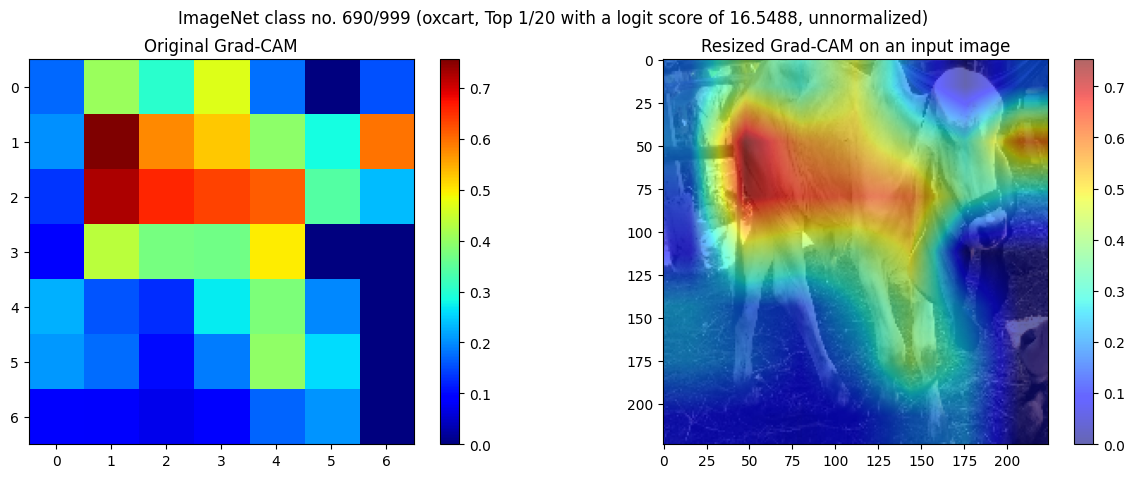

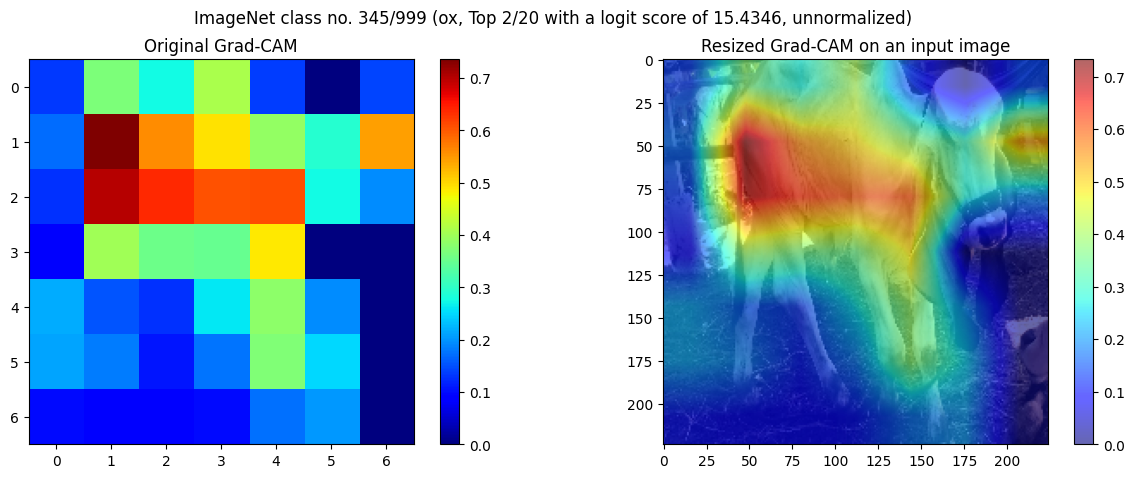

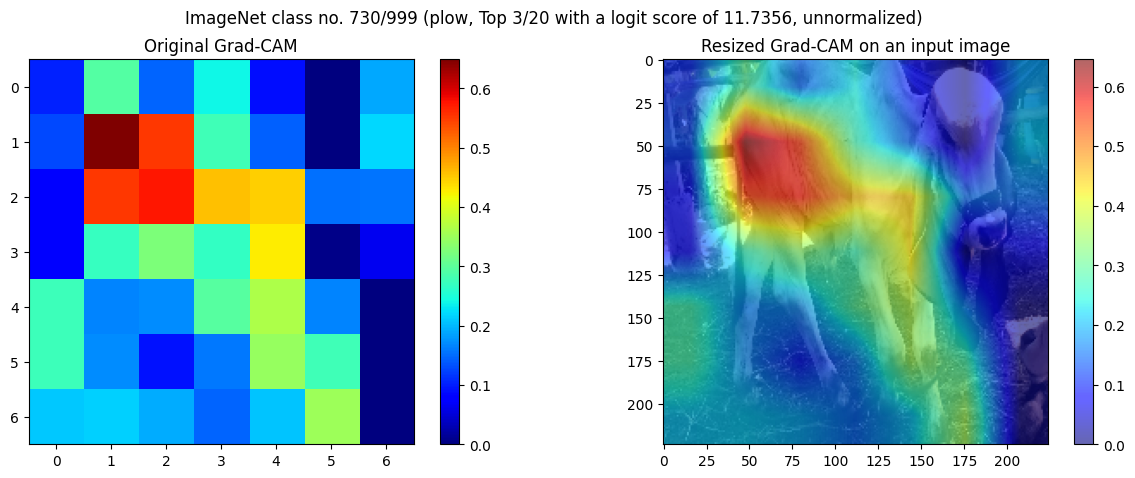

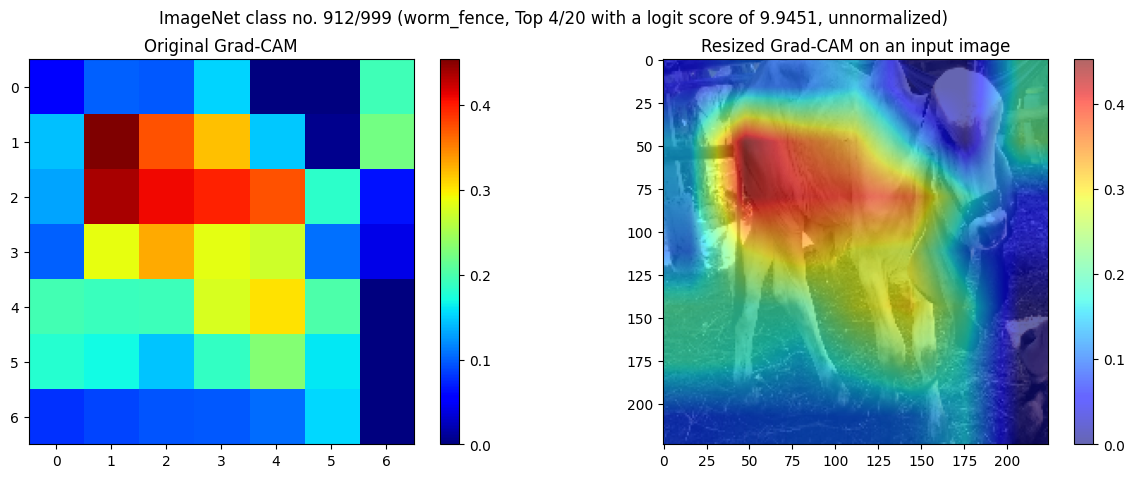

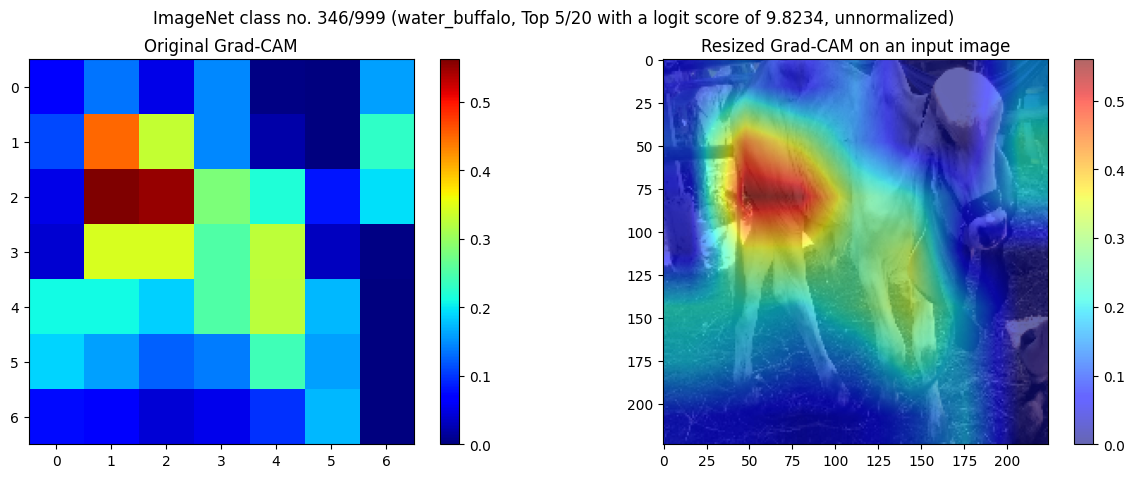

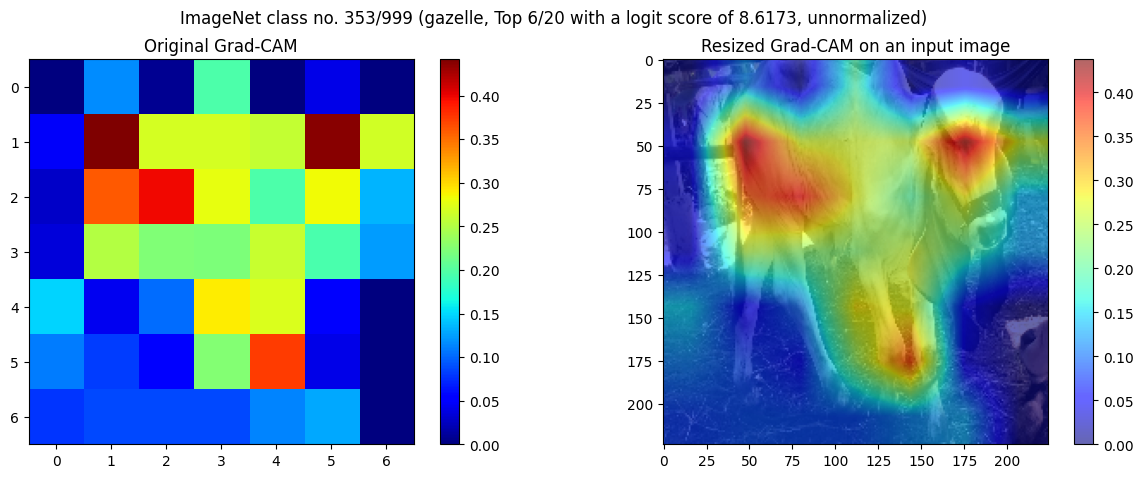

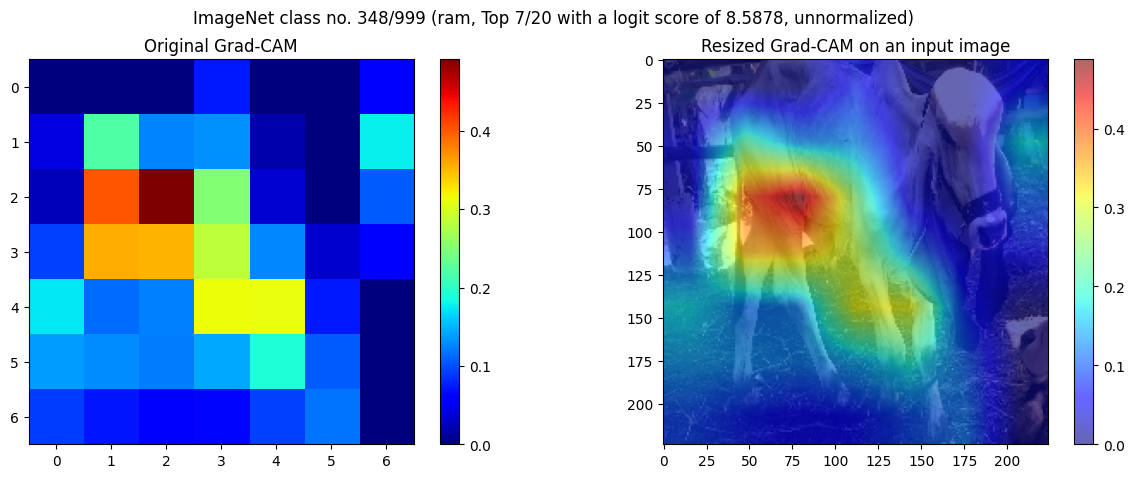

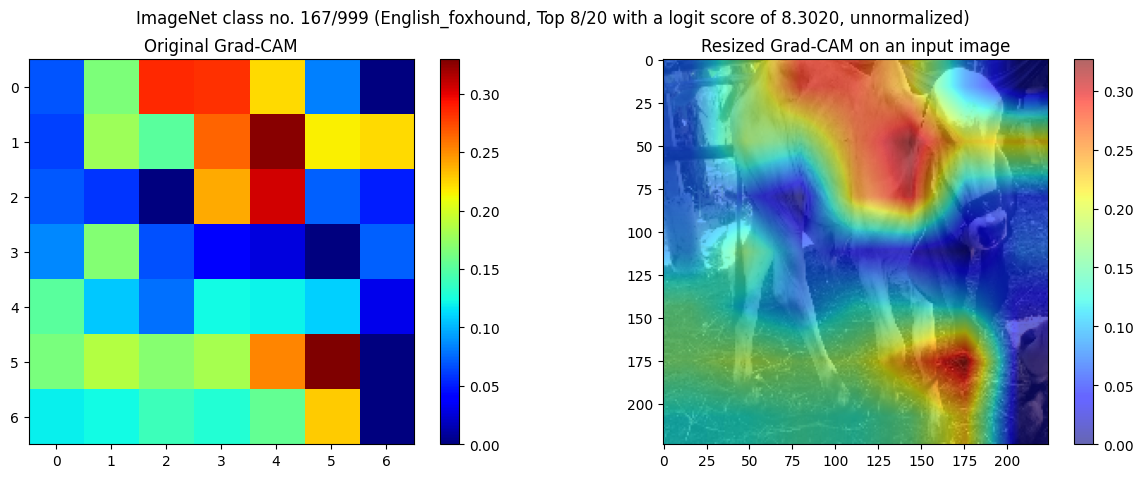

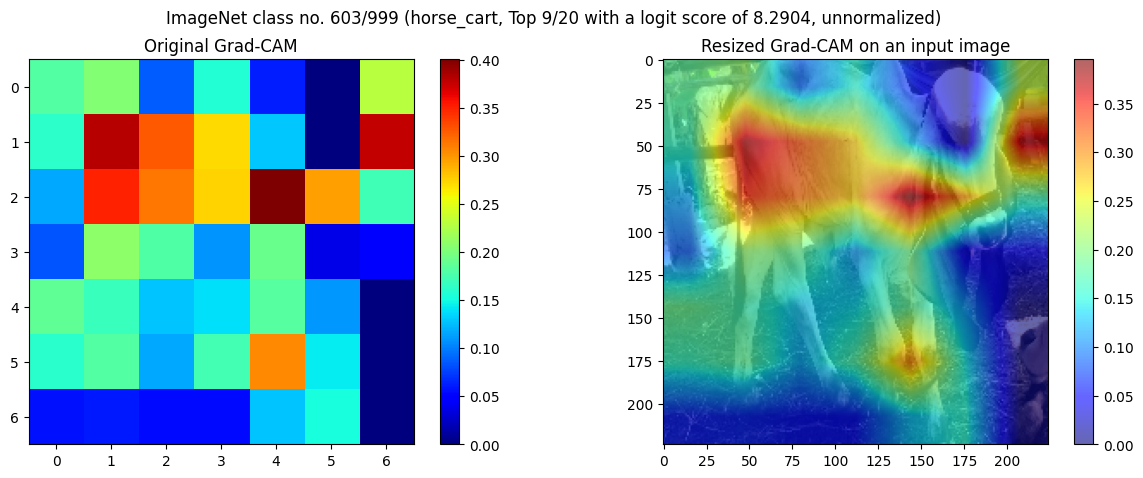

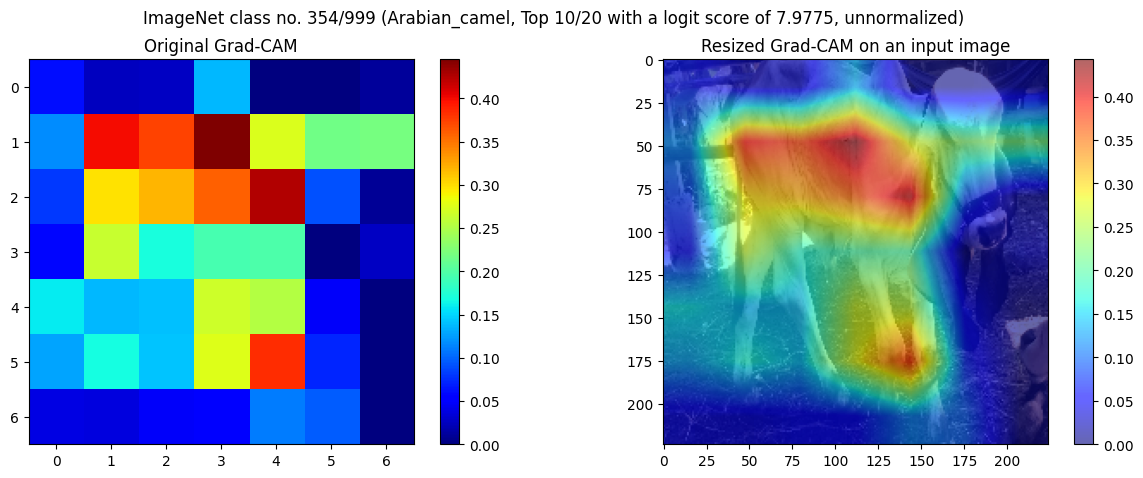

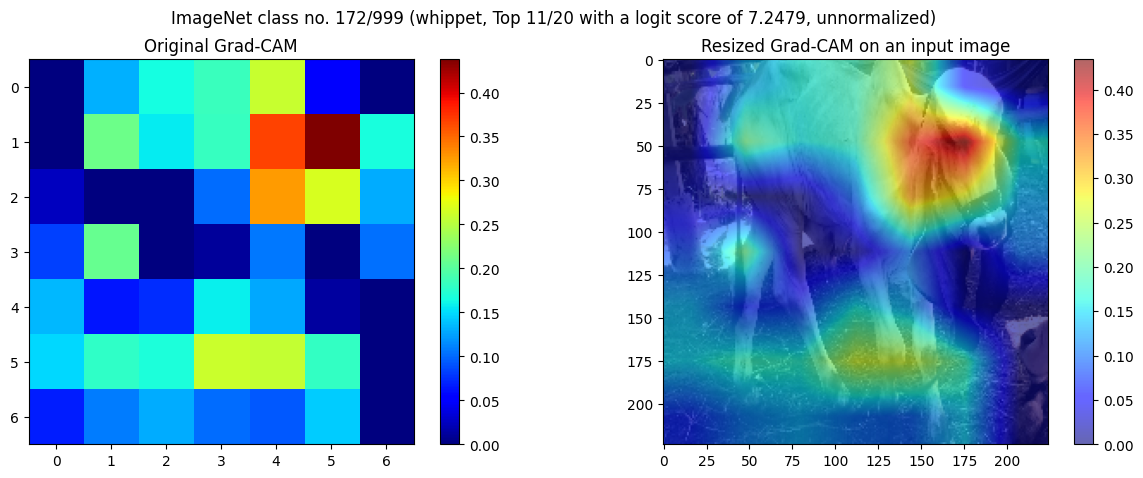

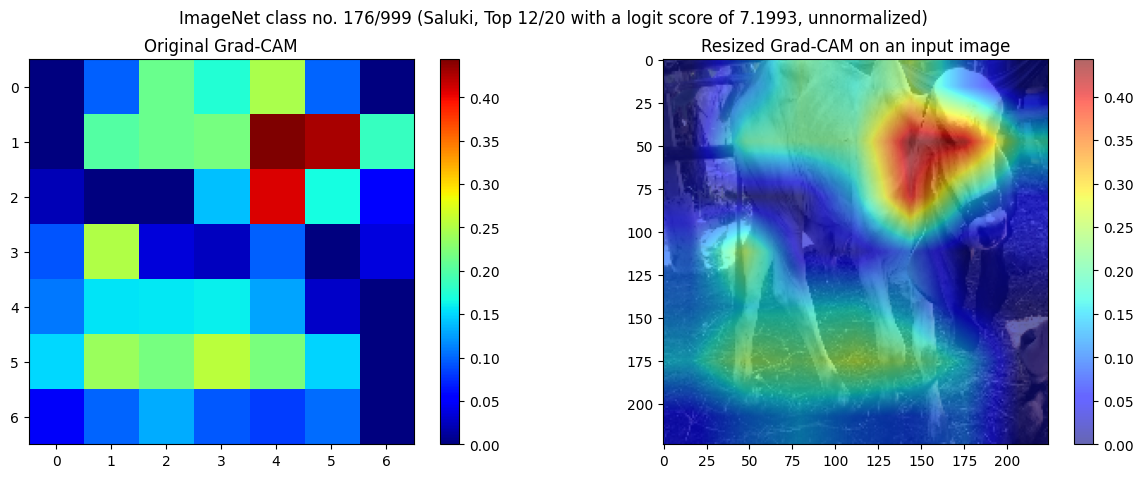

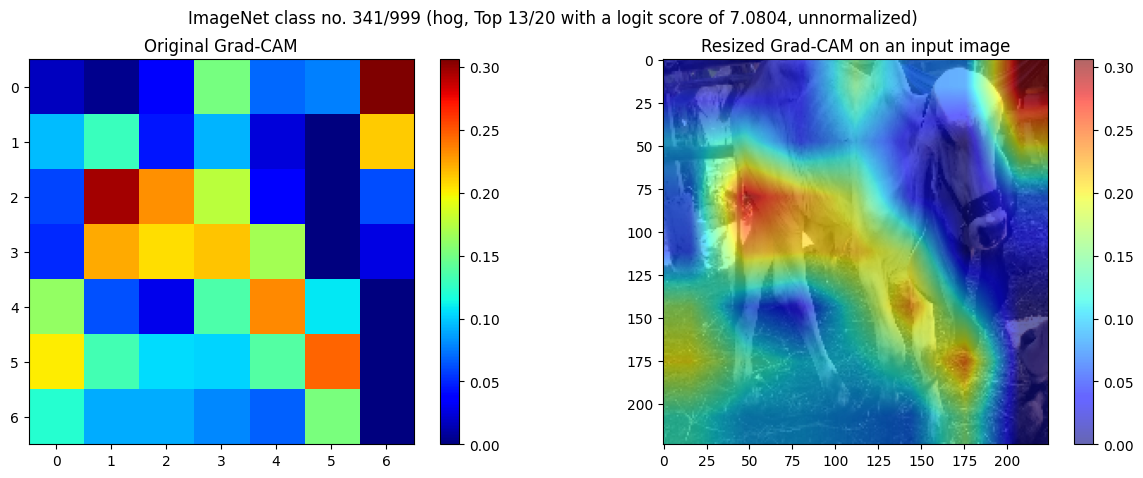

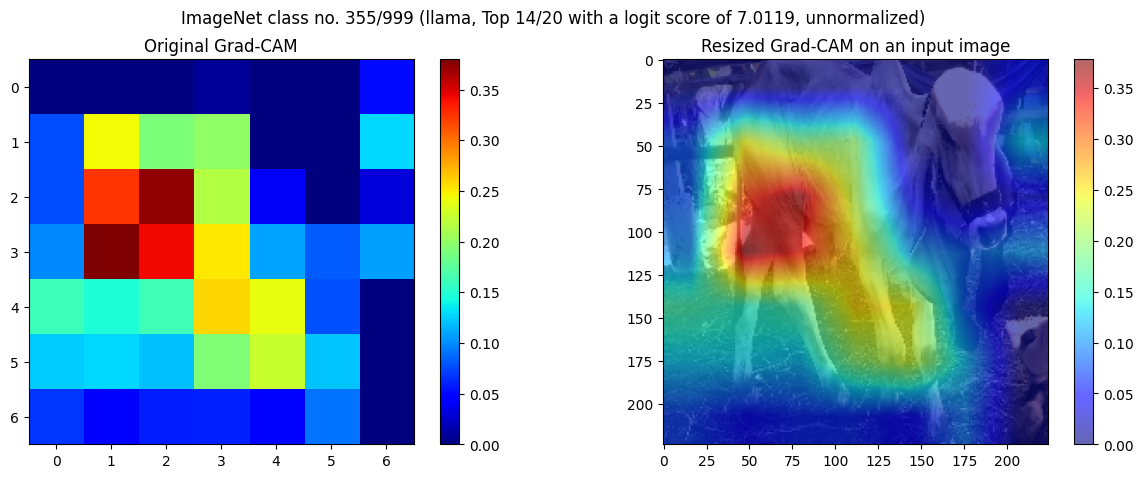

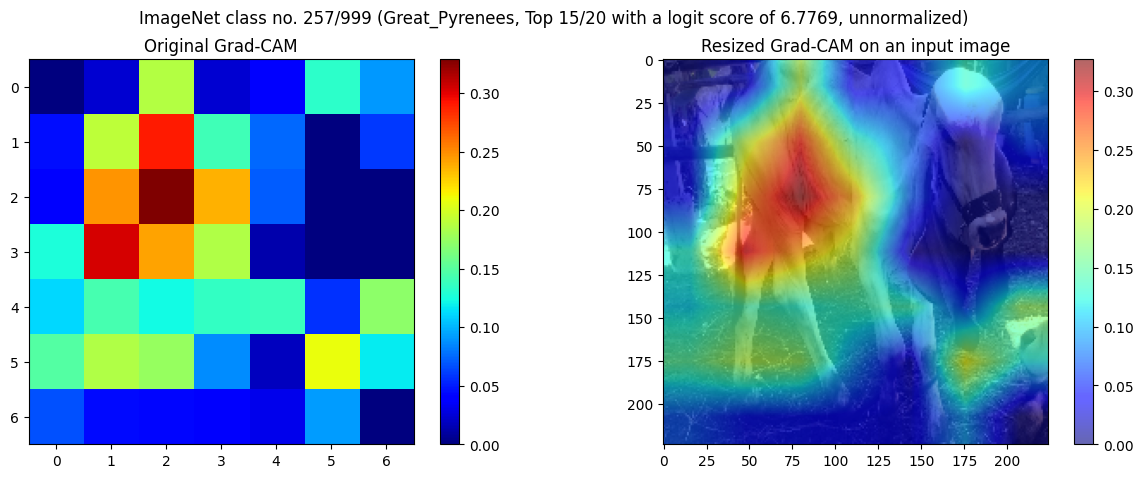

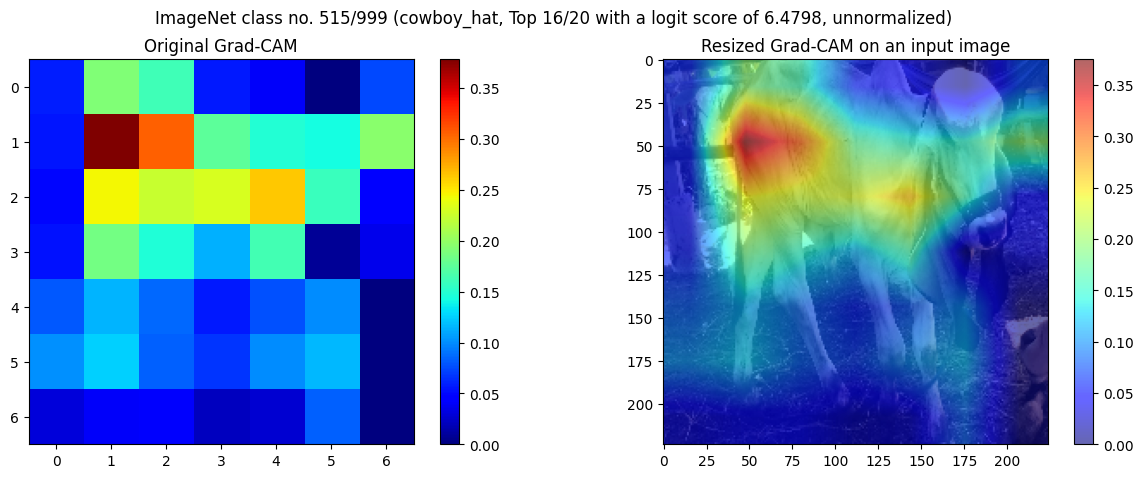

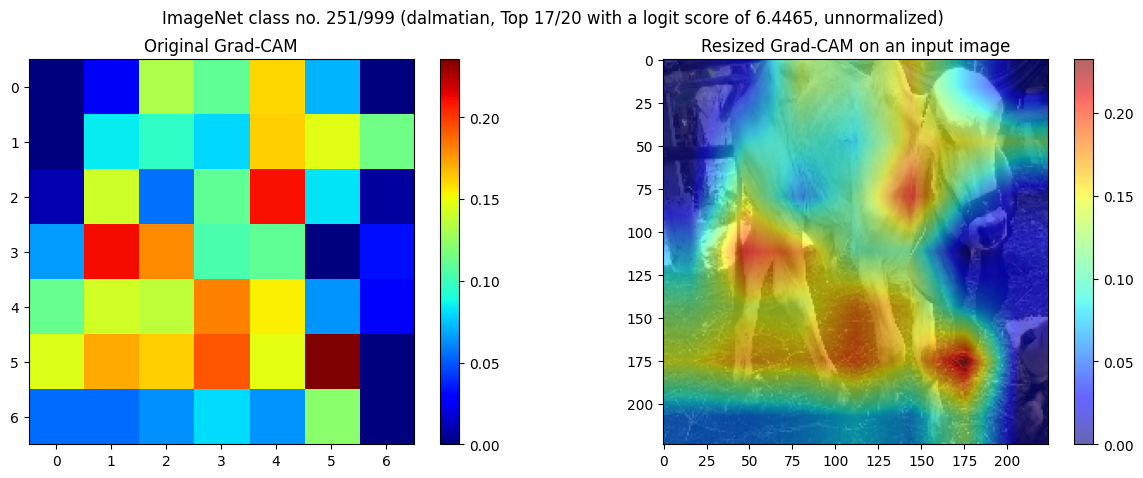

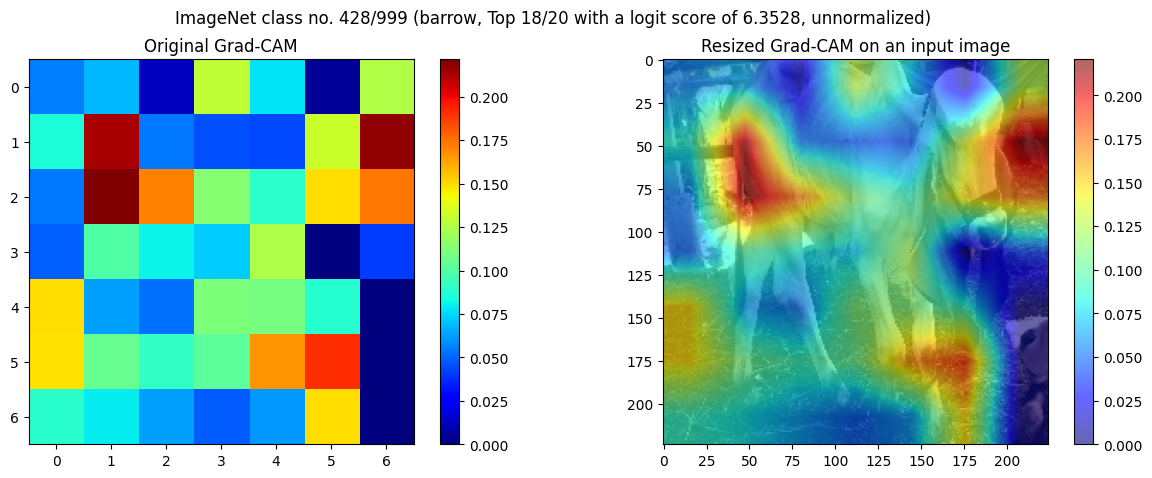

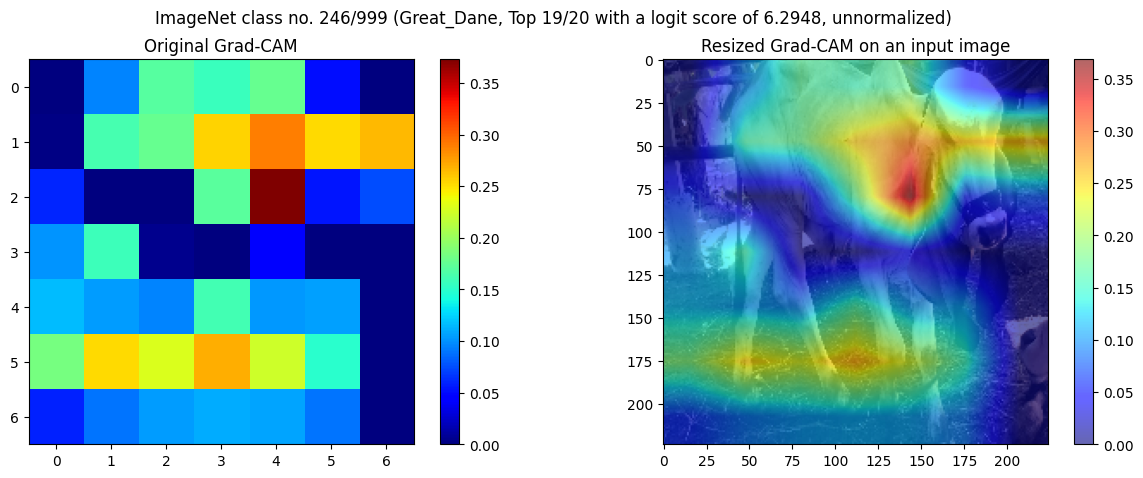

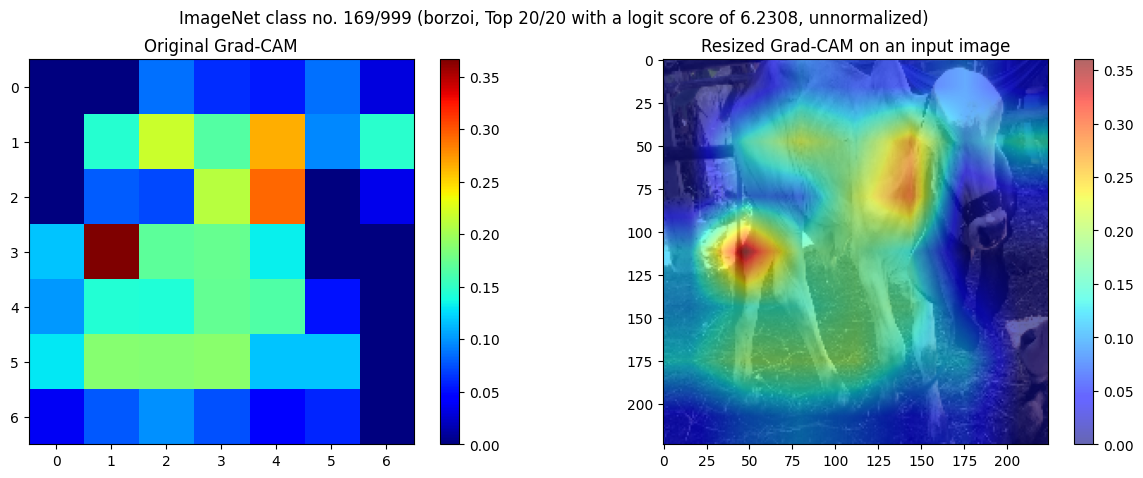

In [107]:
# Test 'img1' with heatmap_norm=False
visualize_GradCAM_topresult( new_model, img1, img_preprocess1, out_linear1, top=20, heatmap_norm=False)

In [18]:
# Test 'img2' with heatmap_norm=True
visualize_GradCAM_topresult( new_model, img2, img_preprocess2, out_linear2, top=20, heatmap_norm=True)

Output hidden; open in https://colab.research.google.com to view.